# ** DIscBIO: a user-friendly pipeline for biomarker discovery in single-cell transcriptomics**

The pipeline consists of four successive steps: data pre-processing, cellular clustering and pseudo-temporal ordering, determining differential expressed genes and identifying biomarkers.

![DIsccBIO](DiscBIO.png)

## Required Packages

In [1]:
library(DIscBIO)
library(partykit)
library(enrichR)

Loading required package: SingleCellExperiment

Loading required package: SummarizedExperiment

Loading required package: GenomicRanges

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tap

## Loading dataset

The valuesG1ms dataset consists of single cells from a myxoid liposarcoma cell line. 
Myxoid liposarcoma is a rare type of tumor driven by specific fusion oncogenes, normally FUS-DDIT3 [Fletcher et al., 2013], with few other genetic changes [Ståhlberg et al., 2014; Hofvander et al., 2018]. The cells were collected based on their cell cycle phase (G1, S or G2/M), assessed by analyzing their DNA content using Fluorescence Activated Cell Sorter [Karlsson et al., 2017]. Data including ERCC spike-ins, are available in the ArrayExpress database at EMBL-EBI with accession number E-MTAB-6142).

The dataset should be formatted in a data frame where columns refer to samples and rows refer to genes. We provide here the possibility to load the dataset either as ".csv" or ".rda" extensions.

In [2]:
FileName<-"valuesG1ms"       # Name of the dataset
CSV=TRUE                     # If the dataset has ".csv", the user shoud set CSV to TRUE
#CSV=FALSE                   # If the dataset has ".rda", the user shoud set CSV to FALSE

if (CSV==TRUE){
    DataSet <- read.csv(file = paste0(FileName,".csv"), sep = ";",header=T)
    rownames(DataSet)<-DataSet[,1]
    DataSet<-DataSet[,-1]
} else{
    load(paste0(FileName,".rda"))
    DataSet<-get(FileName)
}
cat(paste0("The ", FileName," contains:","\n","Genes: ",length(DataSet[,1]),"\n","cells: ",length(DataSet[1,]),"\n"))

The valuesG1ms contains:
Genes: 59838
cells: 94


In [3]:
sc<- DISCBIO(DataSet)       # The DISCBIO class is the central object storing all information generated throughout the pipeline 

## 1. Data Pre-processing

Prior to applying data analysis methods, it is standard to pre-process the raw read counts resulted from the sequencing. The preprocessing approach depends on the existence or absence of ERCC spike-ins. In both cases, it includes normalization of read counts and gene filtering. 

#### Normalization of read counts
To account for RNA composition and sequencing depth among samples (single-cells), the normalization method “median of ratios” is used. This method takes the ratio of the gene instantaneous median to the total counts for all genes in that cell (column median). The gene instantaneous median is the product of multiplying the median of the total counts across all cells (row median) with the read of the target gene in each cell. This normalization method makes it possible to compare the normalized counts for each gene equally between samples.

#### Gene filtering
The key idea in filtering genes is to appoint the genes that manifest abundant variation across samples. Filtering genes is a critical step due to its dramatic impact on the downstream analysis. In case the raw data includes ERCC spike-ins, genes will be filtered based on variability in comparison to a noise level estimated from the ERCC spike-ins according to an algorithm developed by Brennecke et al (Brennecke et al., 2013). This algorithm utilizes the dependence of technical noise on the average read count and fits a model to the ERCC spike-ins. Further gene filtering can be implemented based on gene expression.
In case the raw data does not include ERCC spike-ins, genes will be only filtered based on minimum expression in certain number of cells.


![DataPre-processing](Data-Preprocessing.png)

### 1.1. Filtering and normalizing the raw data that includes ERCCs

Filtering the raw data that includes ERCCs can be done by applying the “NoiseFiltering” function, which includes several parameters:
    - object: the outcome of running the DISCBIO() function.
    - percentile: A numeric value of the percentile. It is used to validate the ERCC spik-ins. Default is 0.8.
    - CV: A numeric value of the coefficient of variation. It is used to validate the ERCC spik-ins. Default is 0.5.
    - geneCol: Color of the genes that did not pass the filtration.
    - FgeneCol: Color of the genes that passt the filtration.
    - erccCol: Color of the ERCC spik-ins.
    - Val: A logical vector that allows plotting only the validated ERCC spike-ins. Default is TRUE. If Val=FALSE will 
      plot all the ERCC spike-ins.
    - plot: A logical vector that allows plotting the technical noise. Default is TRUE. 
    - export: A logical vector that allows writing the final gene list in excel file. Default is TRUE. 
    - quiet: if `TRUE`, suppresses printed output
    
To normalize the raw sequencing reads the function Normalizedata() should be used, this function takes 8 parameters. 
- In case the user would like just to normalize the reads without any further gene filtering the parameters minexpr and minnumber should be set to 0.
- In case the user would like just to normalize the reads and run gene filtering based on gene expression the parameters minexpr and minnumber should have values. This function will discard cells with less than mintotal transcripts. Genes that are not expressed at minexpr transcripts in at least minnumber cells are discarded.
          
The function Normalizedata() normalizes the count reads using the normalization method “median of ratios” 
          
To Finalize the preprocessing the function FinalPreprocessing() should be implemented by setting the parameter "GeneFlitering" to NoiseF ( whether the dditional gene filtering step based on gene expression was implemented on not).

Cut-off value for the ERCCs= 12.5


Coefficients of the fit:



        a0    a1tilde 
 0.0200366 70.4893629 


Explained variances of log CV^2 values= 0.84


Number of genes that passed the filtering = 5684


The gene filtering method = Noise filtering

The Filtered Normalized dataset contains:
Genes: 5684
cells: 94



The Filtered Normalized dataset was saved as: filteredDataset.Rdata



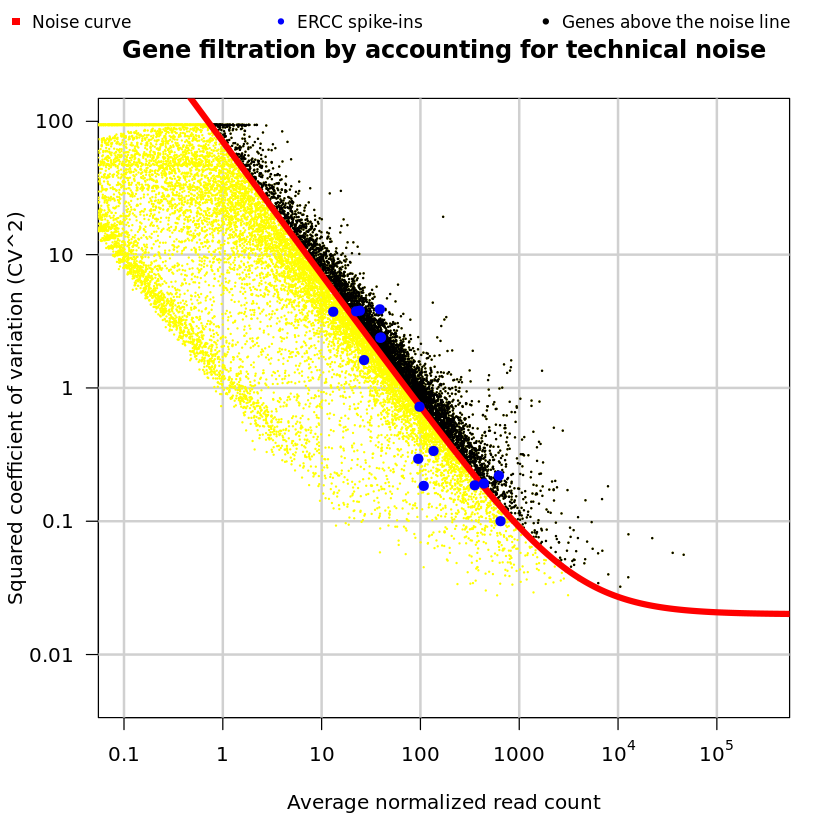

In [4]:
sc<-NoiseFiltering(sc,percentile=0.8, CV=0.3)       

####  Normalizing the reads without any further gene filtering
sc<-Normalizedata(sc, mintotal=1000, minexpr=0, minnumber=0, maxexpr=Inf, downsample=FALSE, dsn=1, rseed=17000) 
sc<-FinalPreprocessing(sc,GeneFlitering="NoiseF",export = TRUE) ### The GeneFiltering can be either "NoiseF" or"ExpF"

## 2. Cellular Clustering and Pseudo Time ordering

Cellular clustering is performed according to the gene expression profiles to detect cellular sub-population with unique properties. After clustering, pseudo-temporal ordering is generated to indicate the cellular differentiation degree. 

![PSCAN](Clustering.png)

## 2.2. Model-Based clustering

![DIsccBIO](MB1.png)

Model-based clustering assumes that the data are generated by a model and attempts to recover the original model from the data to define cellular clusters.

#### 2.2.1. Defining the Cells in the clusters generated by model-based clustering

In [5]:
sc <- Exprmclust(sc,K =3,reduce = TRUE,quiet = TRUE) 

#### 2.2.2. Cluster plotting using PCA and tSNE maps

To visualize the detected clusters, two common dimensionality reduction tools are implemented: tSNE map and principal component analysis (PCA), which is a linear dimensionality reduction method that preserves the global structure and shows how the measurements themselves are related to each other.  

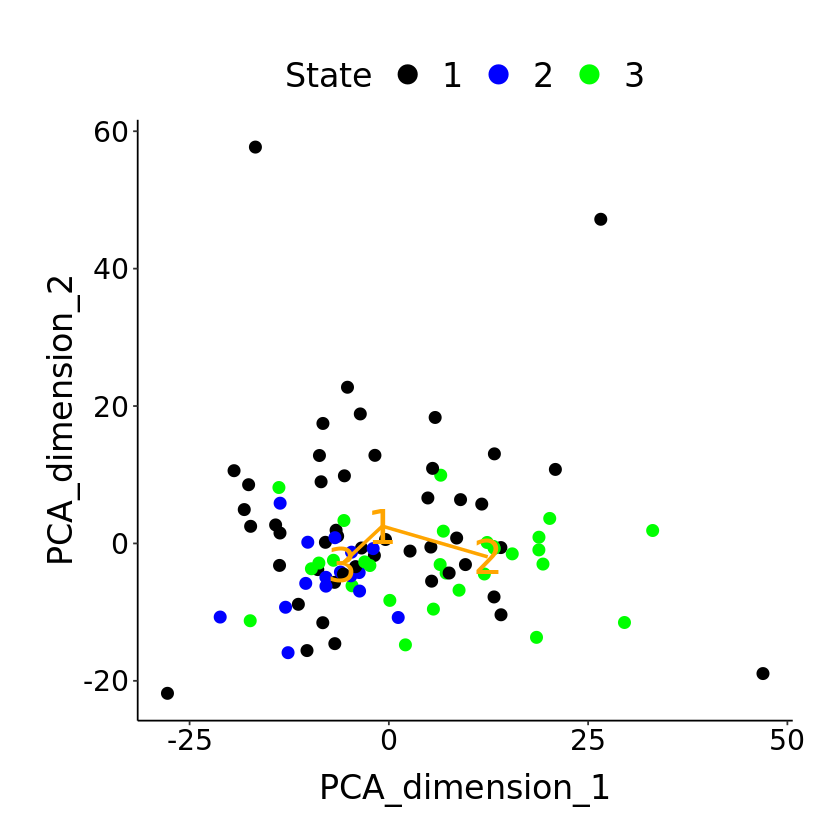

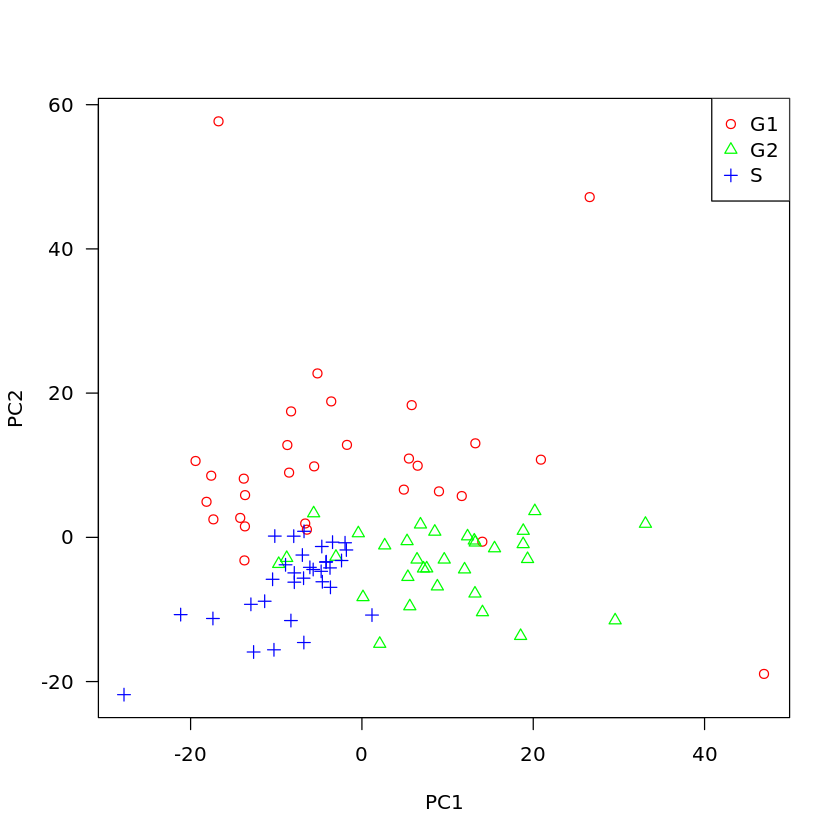

In [6]:
PlotmclustMB(sc)
PCAplotSymbols(sc)

This function may take time

sigma summary: Min. : 38.4914978648748 |1st Qu. : 42.9672869120877 |Median : 45.7336241172451 |Mean : 47.2423249643292 |3rd Qu. : 50.7105126779753 |Max. : 73.7307741725683 |

Epoch: Iteration #500 error is: 0.608233282504434

Epoch: Iteration #1000 error is: 0.597577895108978

Epoch: Iteration #1500 error is: 0.597054005007593

Epoch: Iteration #2000 error is: 0.59478833216114

Epoch: Iteration #2500 error is: 0.785133695910099

Epoch: Iteration #3000 error is: 0.467442752493165

Epoch: Iteration #3500 error is: 0.467349316975901

Epoch: Iteration #4000 error is: 0.467341397783741

Epoch: Iteration #4500 error is: 0.467329835708217

Epoch: Iteration #5000 error is: 0.467315499731271



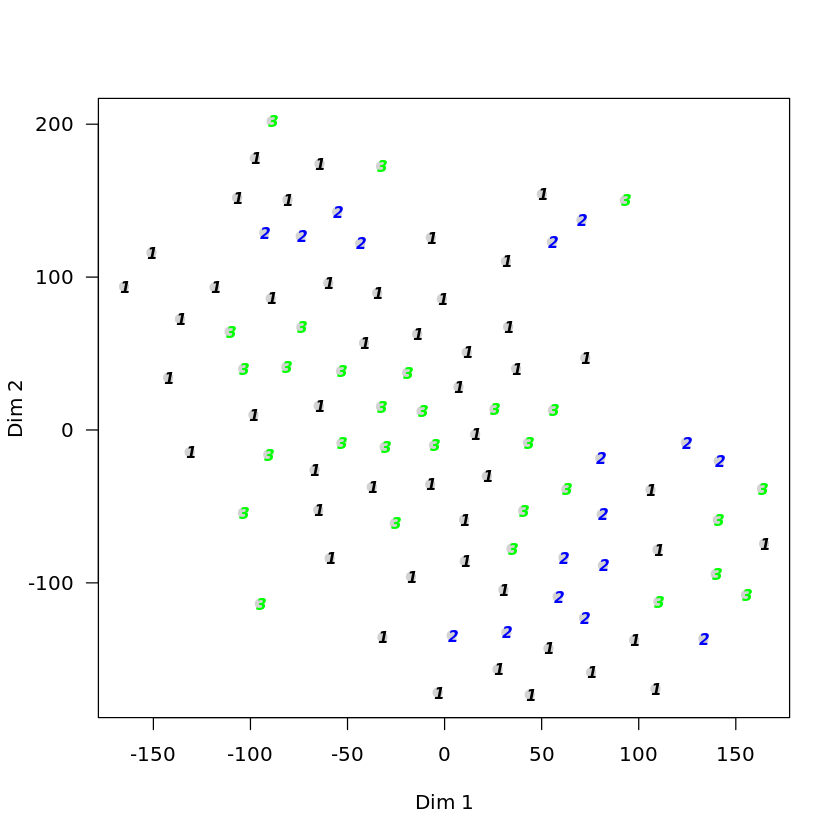

In [7]:
# Plotting the model-based clusters in tSNE maps
sc<- comptSNE(sc,rseed=15555,quiet = F)          # to perform the computation of a t-SNE map
plottSNE(sc)

#### 2.2.3. Evaluating the stability and consistancy of the clusters

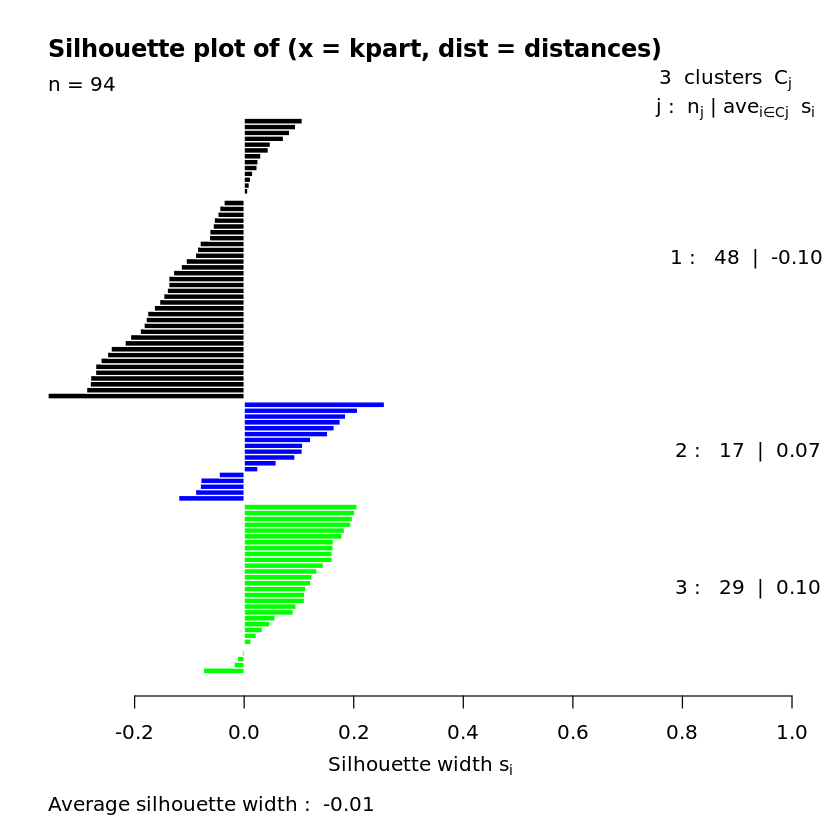

In [8]:
# Silhouette of Model-based clusters
par(mar=c(6,2,4,2))
plotSilhouette(sc,K=3)

[1] 0.660 0.766 0.812

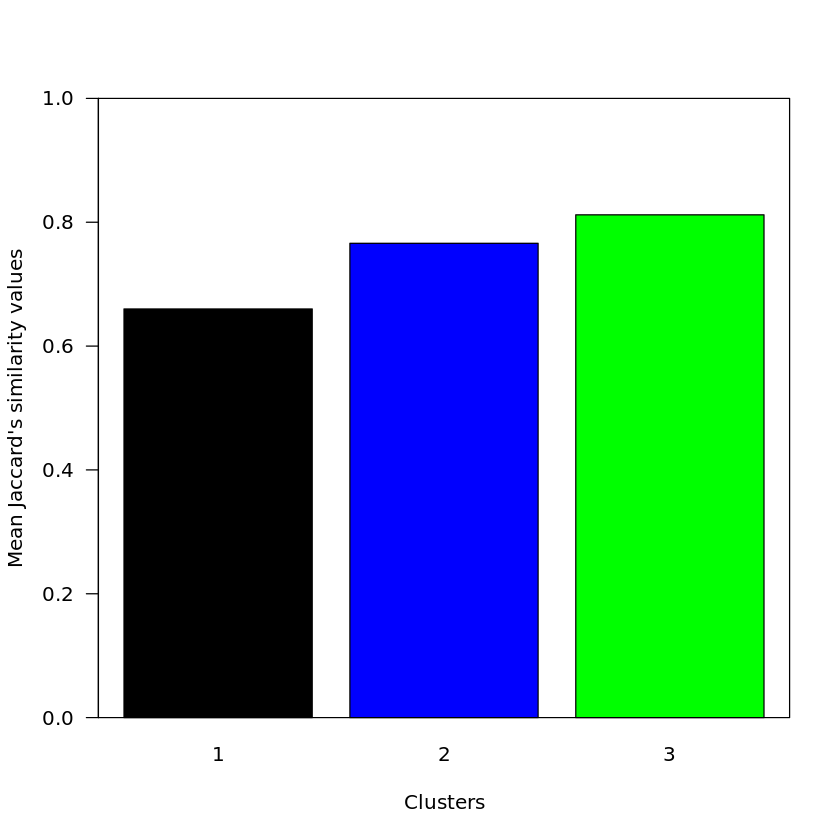

In [9]:
Jaccard(sc,Clustering="MB", K=3, plot = TRUE)    # Jaccard of Model based clusters

### Defining outlier cells based on Model-Based Clustering

Outlier identification is implemented using a background model based on distribution of transcript counts within a cluster. The background model is computed using the mean and the variance of the expression of each gene in a cluster. Outliers are defined as cells with a minimum of “outlg” outlier genes. Here we are setting the minimum number of outlier genes (the “outlg” parameter) to 5% of the number of filtered genes, this is based on the recommendation of De Vienne et al. (De Vienne et al., 2012). 


In case the user decided to remove outlier cells, the user should set RemovingOutliers to TRUE and then start from the beginning (Data Pre-processing). 

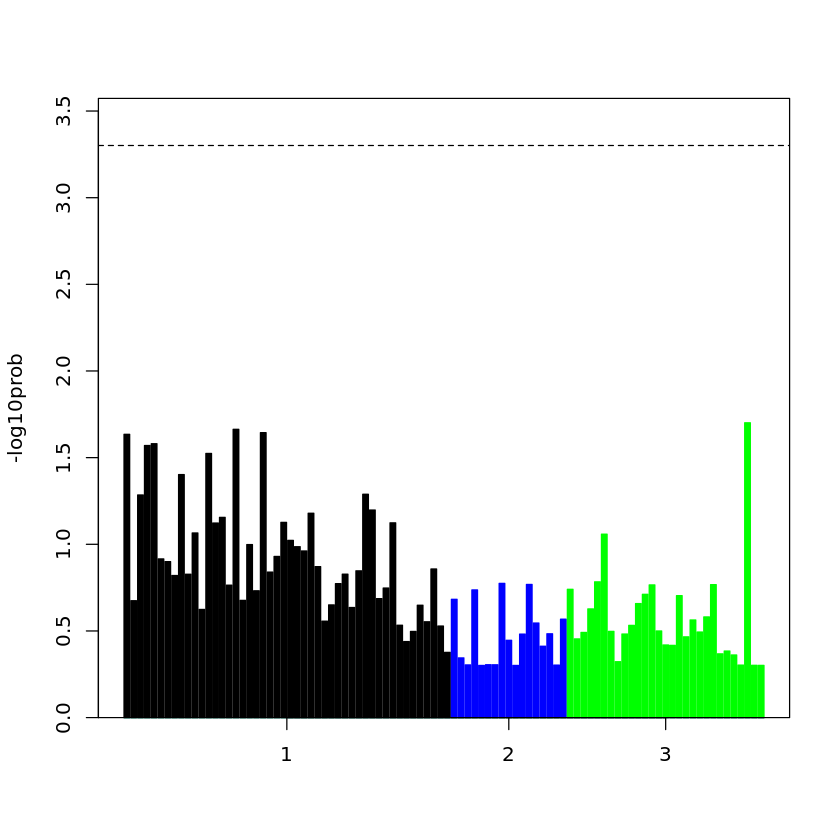

In [10]:
outlg<-round(length(sc@fdata[,1]) * 0.05)     # The cell will be considered as an outlier if it has a minimum of 0.5% of the number of filtered genes as outlier genes. 
Outliers<- FindOutliers(sc, K=3, outminc=5,outlg=outlg,probthr=.5*1e-3,thr=2**-(1:40),outdistquant=.75, plot = TRUE, quiet = T)

RemovingOutliers=FALSE     
# RemovingOutliers=TRUE                    # Removing the defined outlier cells based on K-means Clustering

if(RemovingOutliers==TRUE){
    names(Outliers)=NULL
    Outliers
    DataSet=DataSet[-Outliers]
    dim(DataSet)
    colnames(DataSet)
    cat("Outlier cells were removed, now you need to start from the beginning")
}

### 2.2.4. Cellular pseudo-time ordering based on Model-based clusters

In [11]:
sc<-pseudoTimeOrdering(sc,quiet = FALSE, export = FALSE)

   order orderID
1      1   G2_20
2      2   G2_17
3      3   G2_14
4      4   G2_13
5      5   G2_19
6      6   G1_25
7      7    G2_4
8      8   G2_18
9      9   G2_22
10    10   G2_23
11    11    G2_5
12    12    G2_7
13    13   G2_28
14    14   G2_25
15    15    G2_6
16    16   G2_27
17    17    G2_1
18    18   G1_16
19    19      G2
20    20   G2_10
21    21   G2_12
22    22   G2_29
23    23    G1_7
24    24   G2_24
25    25    G1_4
26    26    G1_9
27    27   G1_26
28    28    G2_8
29    29    G1_1
30    30   G2_30
31    31   G2_31
32    32   G1_20
33    33   G1_15
34    34   G1_29
35    35    G1_3
36    36   G1_21
37    37    G1_8
38    38   G1_13
39    39      G1
40    40   G1_12
41    41   G1_28
42    42   G1_23
43    43   G2_16
44    44   G1_17
45    45   G2_15
46    46   G1_11
47    47   G1_18
48    48   G1_10
49    49   G1_14
50    50    G2_2
51    51     S_6
52    52    G1_5
53    53   G1_24
54    54    G1_6
55    55   G2_21
56    56    G1_2
57    57   G1_22
58    58    S_

#### 2.2.4.1 Plotting the  pseudo-time ordering in a PCA plot

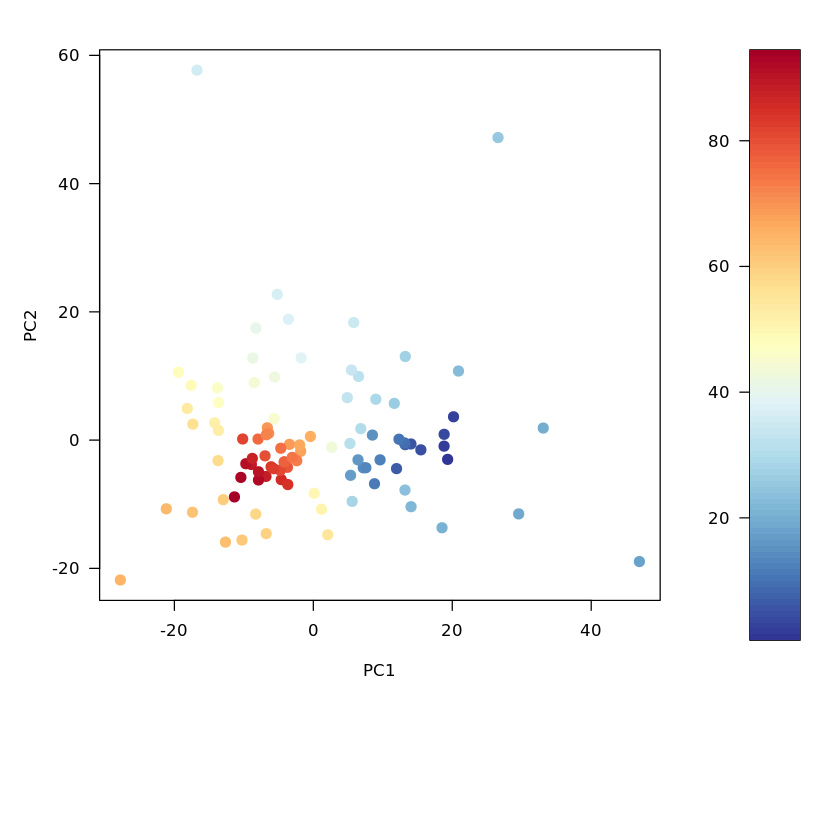

In [12]:
PlotMBpca(sc,type="order")

#### 2.2.4.2 Plotting the  pseudo-time ordering in a tSNE map

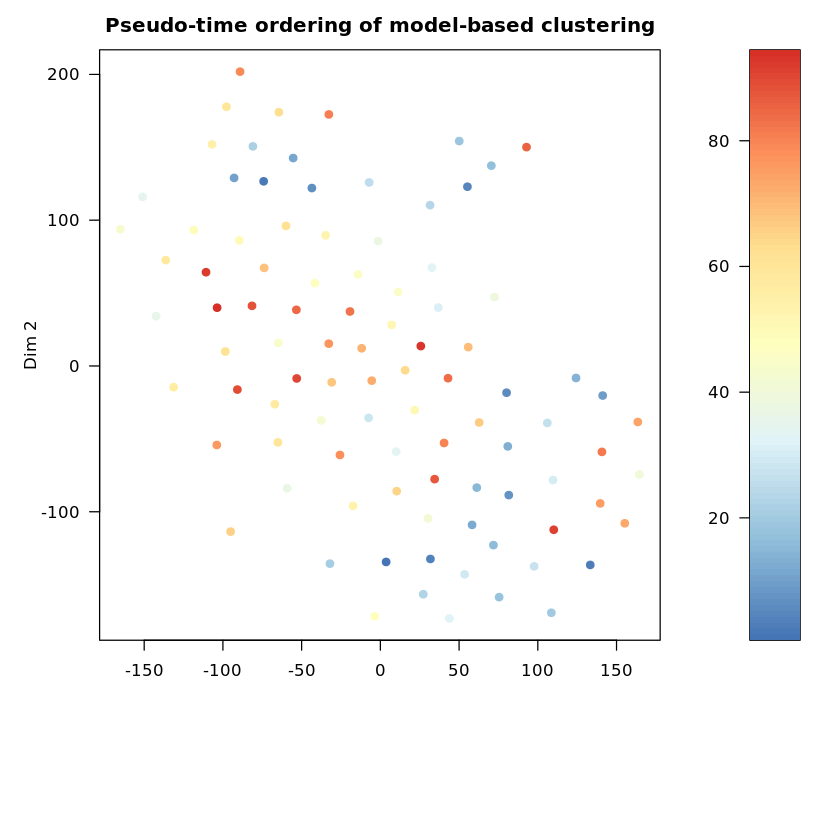

In [13]:
plotOrderTsne(sc)

#### 2.2.4.3 Plotting the Model-based clusters in heatmap

Clustering k = 1,2,..., K.max (= 20): .. done
Bootstrapping, b = 1,2,..., B (= 50)  [one "." per sample]:
.................................................. 50 


[1] 2 1 3

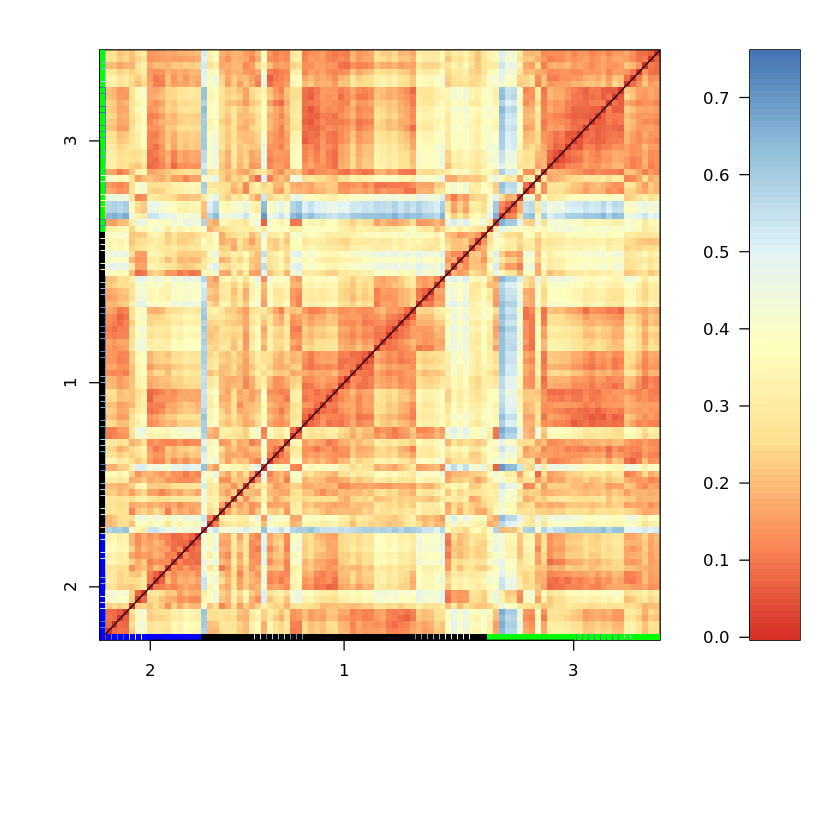

In [14]:
clustheatmap(sc,clustering_method = "model-based")            

#### 2.2.4.4 Plotting the gene expression of a particular gene in a tSNE map

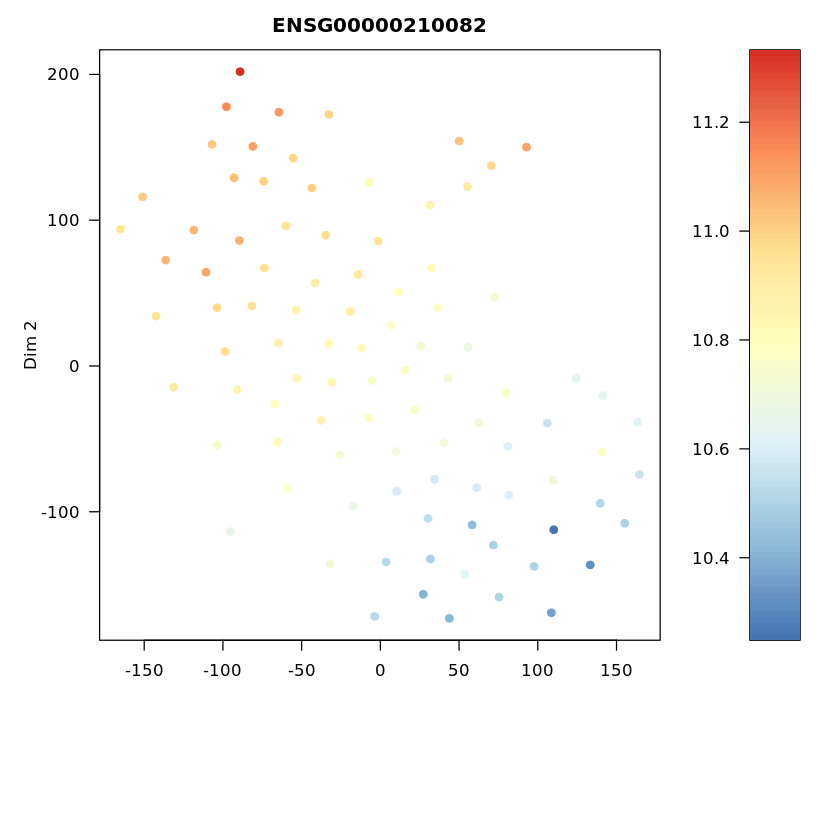

In [15]:
g='ENSG00000210082'                #### Plotting the expression of  MT-RNR2
plotExptSNE(sc,g)

#### 2.2.4.5 Plotting the gene expression of a particular gene in a PCA plot

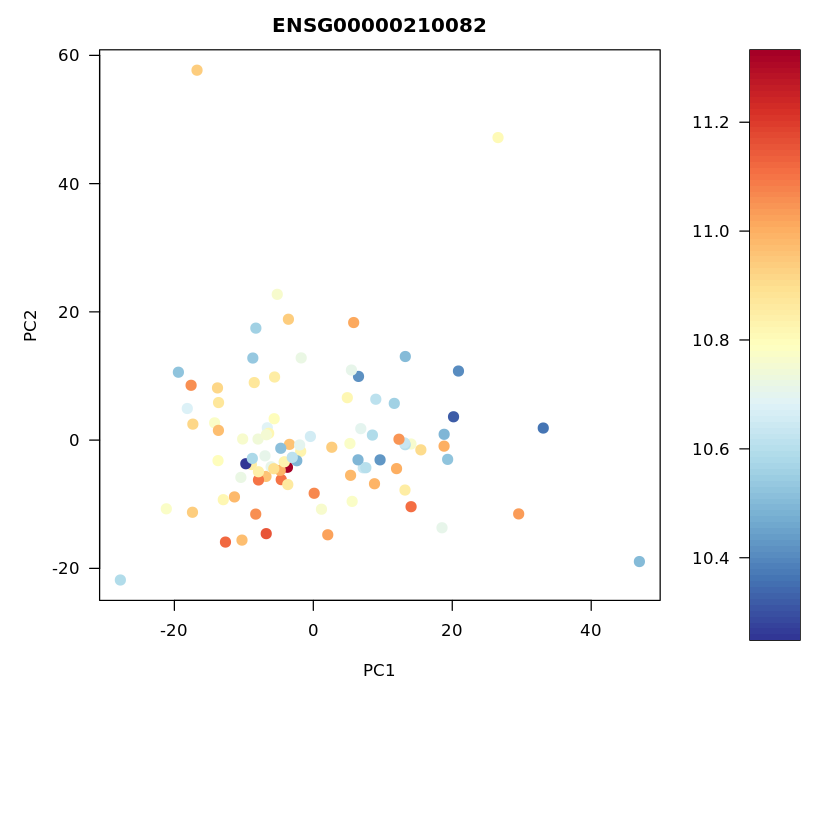

In [16]:
g <- "ENSG00000210082"       #### Plotting the expression of  MT-RNR2
PlotMBpca(sc,g,type="exp")

## 3. Determining differentially expressed genes (DEGs)

Differentially expressed genes between individual clusters are identified using the significance analysis of sequencing data (SAMseq), which is a new function in significance analysis of microarrays (Li and Tibshirani 2011) in the samr package v2.0 (Tibshirani et all., 2015). SAMseq is a non-parametric statistical function dependent on Wilcoxon rank statistic that equalizes the sizes of the library by a resampling method accounting for the various sequencing depths. The analysis is implemented over the pure raw dataset that has the unnormalized expression read counts after excluding the ERCCs. Furthermore, DEGs in each cluster comparing to all the remaining clusters are determined using binomial differential expression, which is based on binomial counting statistics.

![DIsccBIO](MB2.png)

## 3.1 Identifying DEGs using SAMseq

The user can define DEGs between all clusters generated by either K-means or model based clustering by applying the “DEGanalysis” function. Another alternative is to define DEGs between particular clusters generated by either K-means or model based clustering by applying the “DEGanalysis2clust” function. The outcome of these two functions is a list of two components:
- The first component is a data frame showing the Ensembl gage name and the symbole of the detected DEGs
- The second component is table showing the comparisons, Target cluster, Number of genes and the File name. This component will be used for the downstream analysis.

### 3.1.1 Determining DEGs between two particular clusters

Estimating sequencing depths...

Resampling to get new data matrices...

perm = 1

perm = 2

perm = 3

perm = 4

perm = 5

perm = 6

perm = 7

perm = 8

perm = 9

perm = 10

perm = 11

perm = 12

perm = 13

perm = 14

perm = 15

perm = 16

perm = 17

perm = 18

perm = 19

perm = 20

perm = 21

perm = 22

perm = 23

perm = 24

perm = 25

perm = 26

perm = 27

perm = 28

perm = 29

perm = 30

perm = 31

perm = 32

perm = 33

perm = 34

perm = 35

perm = 36

perm = 37

perm = 38

perm = 39

perm = 40

perm = 41

perm = 42

perm = 43

perm = 44

perm = 45

perm = 46

perm = 47

perm = 48

perm = 49

perm = 50

perm = 51

perm = 52

perm = 53

perm = 54

perm = 55

perm = 56

perm = 57

perm = 58

perm = 59

perm = 60

perm = 61

perm = 62

perm = 63

perm = 64

perm = 65

perm = 66

perm = 67

perm = 68

perm = 69

perm = 70

perm = 71

perm = 72

perm = 73

perm = 74

perm = 75

perm = 76

perm = 77

perm = 78

perm = 79

perm = 80

perm = 81

perm = 82

perm = 83

perm = 84

perm = 85

p

DEGsE,DEGsS
ENSG00000010292,NCAPD2
ENSG00000011426,ANLN
ENSG00000024526,DEPDC1
ENSG00000072571,HMMR
ENSG00000076382,SPAG5
ENSG00000079616,KIF22


,Comparisons,Target cluster,Gene number,File name,Gene number,File name
,<chr>,<chr>,<int>,<chr>,<int>,<chr>
1,CL2 VS CL3,CL3,26,Up-regulated-NameCL3inCL2VSCL3.csv,146,Low-regulated-NameCL3inCL2VSCL3.csv
2,CL2 VS CL3,CL2,26,Low-regulated-NameCL2inCL2VSCL3.csv,146,Up-regulated-NameCL2inCL2VSCL3.csv


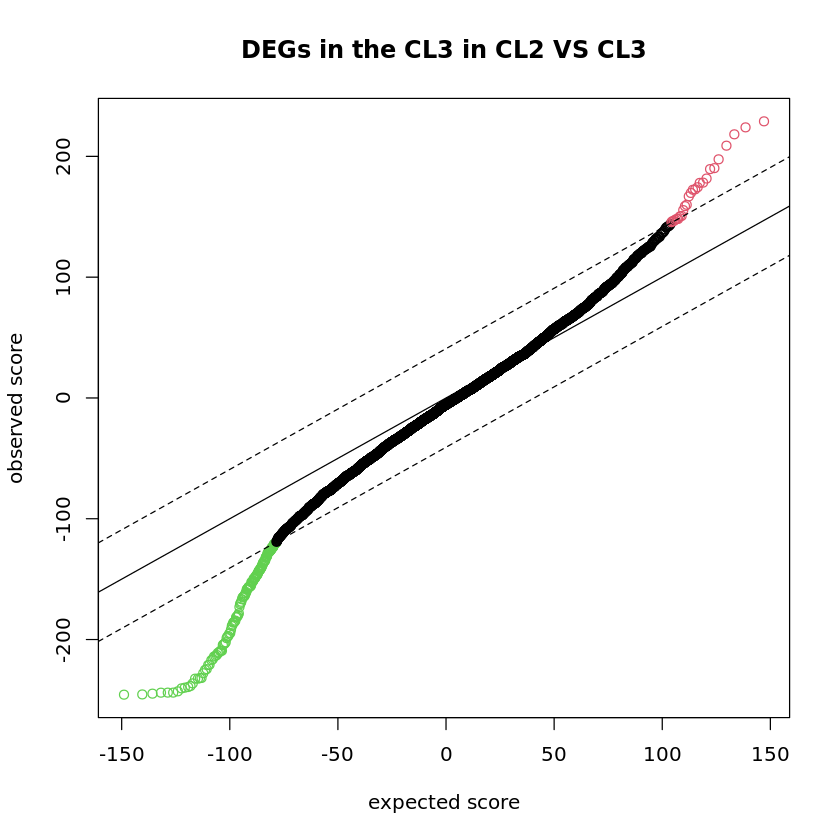

In [17]:
####### differential expression analysis between cluster 2 and cluster 3 of the Model-Based clustering using FDR of 0.05
MBcdiff<-DEGanalysis2clust(sc,Clustering="MB",K=3,fdr=0.05,name="Name",First="CL2",Second="CL3",export = TRUE,quiet=TRUE)   
#### To show the result table
head(MBcdiff[[1]])                  # The first component 
head(MBcdiff[[2]])                  # The second component 

### 3.1.2 Determining DEGs between all clusters

##                                         ¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤ Running this cell will overwrite the previous one ¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤

Estimating sequencing depths...

Resampling to get new data matrices...

perm = 1

perm = 2

perm = 3

perm = 4

perm = 5

perm = 6

perm = 7

perm = 8

perm = 9

perm = 10

perm = 11

perm = 12

perm = 13

perm = 14

perm = 15

perm = 16

perm = 17

perm = 18

perm = 19

perm = 20

perm = 21

perm = 22

perm = 23

perm = 24

perm = 25

perm = 26

perm = 27

perm = 28

perm = 29

perm = 30

perm = 31

perm = 32

perm = 33

perm = 34

perm = 35

perm = 36

perm = 37

perm = 38

perm = 39

perm = 40

perm = 41

perm = 42

perm = 43

perm = 44

perm = 45

perm = 46

perm = 47

perm = 48

perm = 49

perm = 50

perm = 51

perm = 52

perm = 53

perm = 54

perm = 55

perm = 56

perm = 57

perm = 58

perm = 59

perm = 60

perm = 61

perm = 62

perm = 63

perm = 64

perm = 65

perm = 66

perm = 67

perm = 68

perm = 69

perm = 70

perm = 71

perm = 72

perm = 73

perm = 74

perm = 75

perm = 76

perm = 77

perm = 78

perm = 79

perm = 80

perm = 81

perm = 82

perm = 83

perm = 84

perm = 85

p

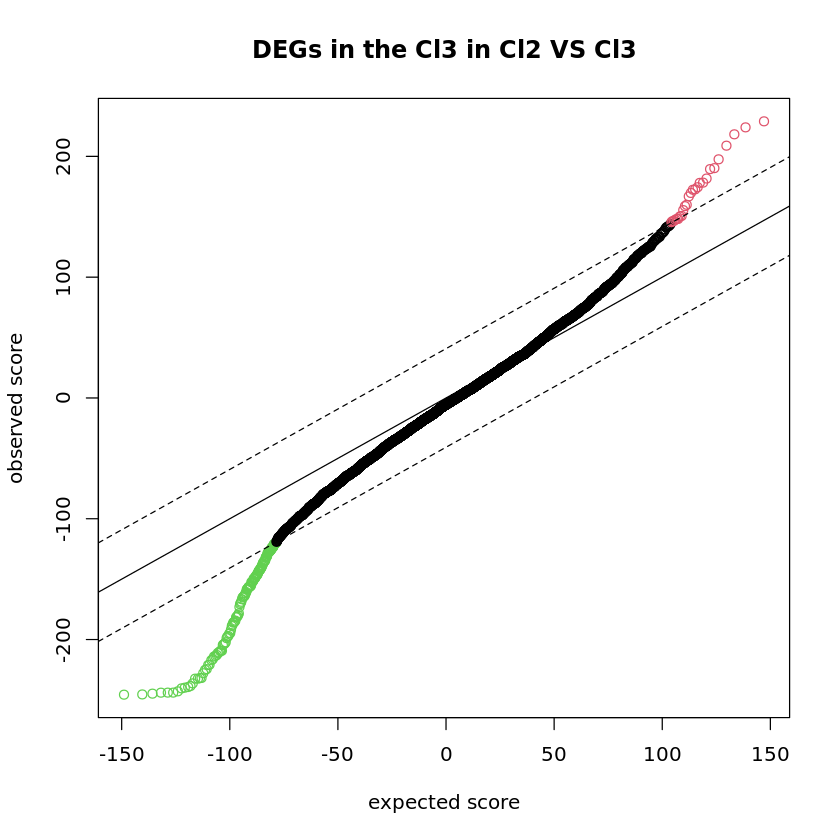

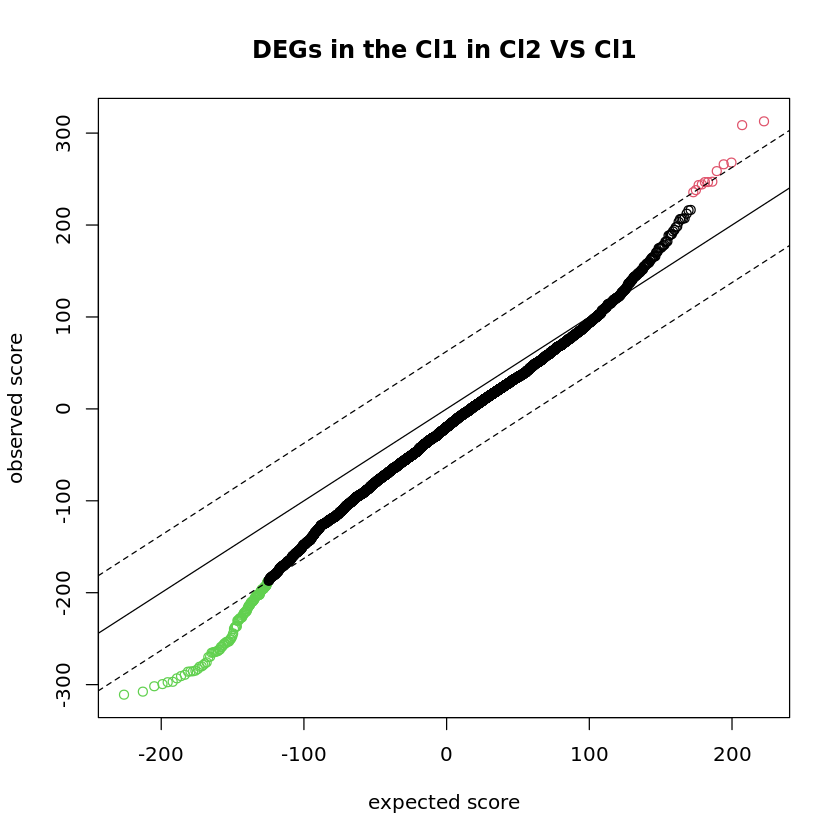

DEGsE,DEGsS
ENSG00000010292,NCAPD2
ENSG00000011426,ANLN
ENSG00000024526,DEPDC1
ENSG00000072571,HMMR
ENSG00000076382,SPAG5
ENSG00000079616,KIF22


,Comparisons,Target cluster,Gene number,File name,Gene number,File name
,<chr>,<chr>,<int>,<chr>,<int>,<chr>
1,Cl2 VS Cl3,Cl3,26,Up-regulated-all_clustersCl3inCl2VSCl3.csv,146,Low-regulated-all_clustersCl3inCl2VSCl3.csv
2,Cl2 VS Cl1,Cl1,12,Up-regulated-all_clustersCl1inCl2VSCl1.csv,115,Low-regulated-all_clustersCl1inCl2VSCl1.csv
3,Cl3 VS Cl1,Cl1,0,Up-regulated-all_clustersCl1inCl3VSCl1.csv,10,Low-regulated-all_clustersCl1inCl3VSCl1.csv
4,Cl2 VS Cl3,Cl2,26,Low-regulated-all_clustersCl2inCl2VSCl3.csv,146,Up-regulated-all_clustersCl2inCl2VSCl3.csv
5,Cl2 VS Cl1,Cl2,12,Low-regulated-all_clustersCl2inCl2VSCl1.csv,115,Up-regulated-all_clustersCl2inCl2VSCl1.csv
6,Cl3 VS Cl1,Cl3,0,Low-regulated-all_clustersCl3inCl3VSCl1.csv,10,Up-regulated-all_clustersCl3inCl3VSCl1.csv


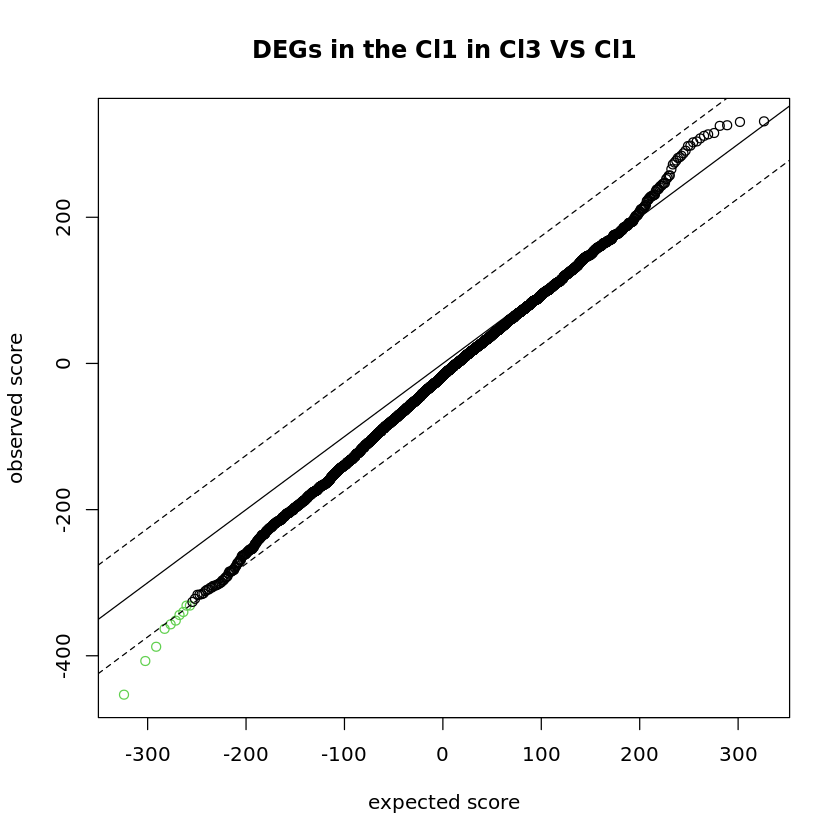

In [18]:
MBcdiff<-DEGanalysis(sc,Clustering="MB",K=3,fdr=0.05,name="all_clusters",export = TRUE,quiet=TRUE)   ####### differential expression analysis between all clusters
#### To show the result table
head(MBcdiff[[1]])                  # The first component 
head(MBcdiff[[2]])                  # The second component

#### 3.2 Identifying DEGs using binomial differential expression

The function MBClustDiffGenes identifies differentially regulated genes for each cluster of the Model-Based clustering in 
comparison to the ensemble of all cells. It returns a list with a data.frame element for each cluster that contains the mean expression across all cells not in the cluster (mean.ncl) and in the cluster (mean.cl), the fold-change in the cluster versus all remaining cells (fc), and the p-value for differential expression between all cells in a cluster and all remaining cells. The p-value is computed based on the overlap of negative binomials fitted to the count distributions within the two groups akin to DESeq.

In [19]:
MBcdiffBinomial<-ClustDiffGenes(sc,K=3,fdr=.01,export=TRUE, quiet=T)    ########## Binomial differential expression analysis
#### To show the result table
head(MBcdiffBinomial[[1]])                  # The first component 
head(MBcdiffBinomial[[2]])                  # The second component

DEGsE,DEGsS
ENSG00000075624,ACTB
ENSG00000094804,CDC6
ENSG00000103187,COTL1
ENSG00000112118,MCM3
ENSG00000115263,GCG
ENSG00000116062,MSH6


,Target Cluster,VS,Gene number,File name,Gene number,File name
,<chr>,<chr>,<int>,<chr>,<int>,<chr>
1,Cluster 1,Remaining Clusters,9,Up-DEG-cluster1.csv,21,Down-DEG-cluster1.csv
2,Cluster 2,Remaining Clusters,314,Up-DEG-cluster2.csv,295,Down-DEG-cluster2.csv
3,Cluster 3,Remaining Clusters,53,Up-DEG-cluster3.csv,109,Down-DEG-cluster3.csv


### Plotting the DEGs

Volcano plots are used to readily show the DEGs by plotting significance versus fold-change on the y and x axes, respectively.

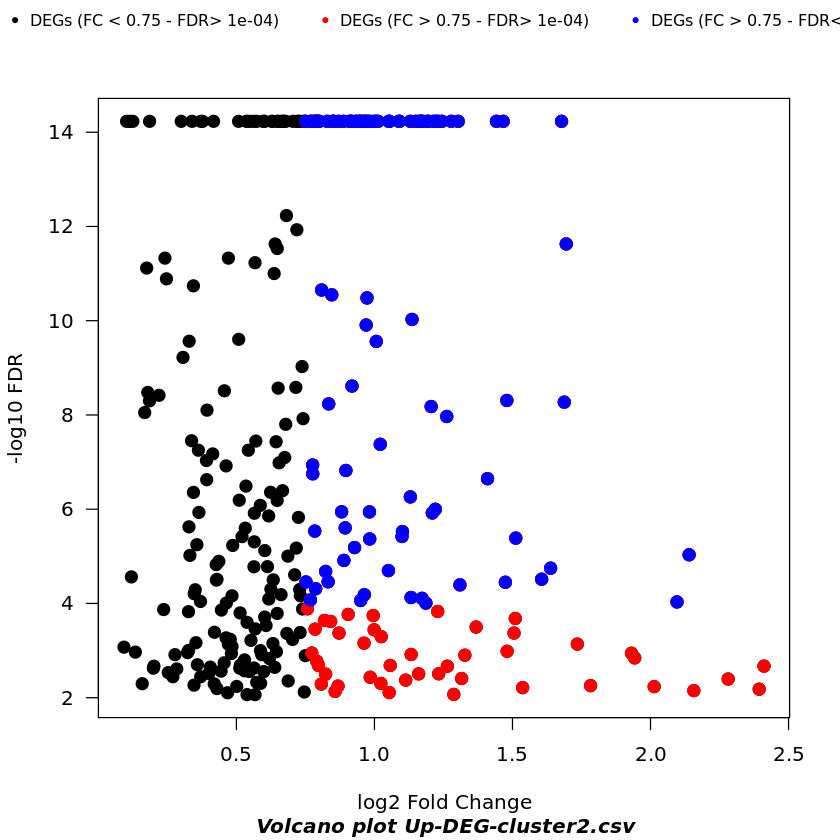

In [20]:
name<-MBcdiffBinomial[[2]][2,4]    ############ Selecting the "Up-DEG-cluster2.csv " from the DEGs' binomial table  ##############
U<-read.csv(file=paste0(name),head=TRUE,sep=",")
Vplot<-VolcanoPlot(U,value=0.0001,name=name,FS=0.8,fc=0.75)

## 4. Identifying biomarkers (decision trees and networking analysis) 

There are several methods to identify biomarkers, among them are decision trees and hub detection through networking analysis. The outcome of STRING analysis is stored in tab separated values (TSV) files. These TSV files served as an input to check both the connectivity degree and the betweenness centrality, which reflects the communication flow in the defined PPI networks 

![DIsccBIO](MB3.png)

Decision trees are one of the most efficient classification techniques in biomarkers discovery.  Here we use it to predict the sub-population of a target cell based on transcriptomic data. Two types of decision trees can be performed: classification and regression trees (CART) and J48. The decision tree analysis is implemented over a training dataset, which consisted of the DEGs obtained by either SAMseq or the binomial differential expression. The performance of the generated trees can be evaluated for error estimation by ten-fold cross validation assessment using the "J48DTeval" and "RpartEVAL" functions.
The decision tree analysis requires the dataset to be class vectored by applying the “ClassVectoringDT” function.

In [21]:
sigDEG<-MBcdiff[[1]]               # DEGs gene list from SANseq
#sigDEG<-MBcdiffBinomial[[1]]      # DEGs gene list from Binomial analysis
First="CL2"
Second="CL3"
DATAforDT<-ClassVectoringDT(sc,Clustering="MB",K=3,First=First,Second=Second,sigDEG)

The DEGs filtered normalized dataset contains:
Genes: 213
cells: 46



### 4.1. J48 Decision Tree

J48 pruned tree
------------------

KIF20A <= 471.86359: CL3 (30.0/1.0)
KIF20A > 471.86359: CL2 (16.0)

Number of Leaves  : 	2

Size of the tree : 	3




=== Summary ===

Correctly Classified Instances          45               97.8261 %
Incorrectly Classified Instances         1                2.1739 %
Kappa statistic                          0.9528
Mean absolute error                      0.042 
Root mean squared error                  0.145 
Relative absolute error                  8.9922 %
Root relative squared error             30.0308 %
Total Number of Instances               46     

=== Confusion Matrix ===

  a  b   <-- classified as
 16  1 |  a = CL2
  0 29 |  b = CL3

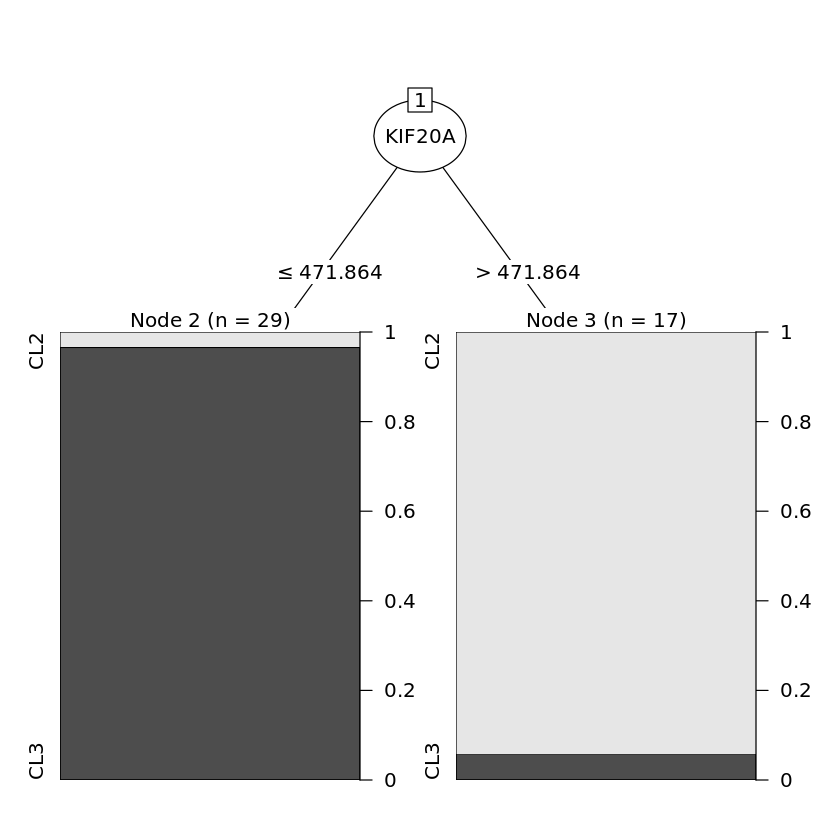

In [22]:
j48dt<-J48DT(DATAforDT)
summary(j48dt) 

#### 4.1.1. Evaluating the performance of the J48 Decision Tree

In [23]:
j48dt<-J48DTeval(DATAforDT,num.folds=10,First=First,Second=Second)

Fold 1 of 10

Fold 2 of 10

Fold 3 of 10

Fold 4 of 10

Fold 5 of 10

Fold 6 of 10

Fold 7 of 10

Fold 8 of 10

Fold 9 of 10

Fold 10 of 10



TP FN FP TN 
14  3  4 25 
             CL2 CL3
PredictedCL2  14   4
PredictedCL3   3  25


J48 SN: 0.82
J48 SP: 0.86
J48 ACC: 0.85
J48 MCC: 0.68




### 4.2. RPART Decision Tree

n= 46 

node), split, n, loss, yval, (yprob)
      * denotes terminal node

1) root 46 17 CL3 (0.36956522 0.63043478)  
  2) AURKA>=543.8824 18  1 CL2 (0.94444444 0.05555556)  
    4) CDC27>=68.20032 17  0 CL2 (1.00000000 0.00000000) *
    5) CDC27< 68.20032 1  0 CL3 (0.00000000 1.00000000) *
  3) AURKA< 543.8824 28  0 CL3 (0.00000000 1.00000000) *


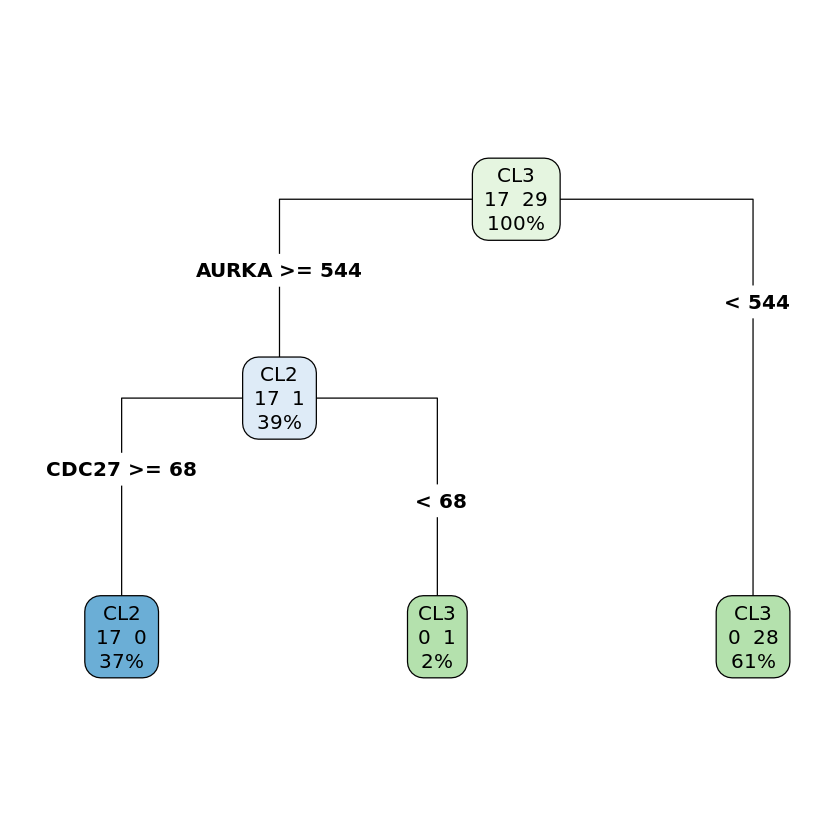

In [24]:
rpartDT<-RpartDT(DATAforDT)

#### 4.2.1. Evaluating the performance of the RPART Decision Tree

In [25]:
rpartEVAL<-RpartEVAL(DATAforDT,num.folds=10,First=First,Second=Second)

Fold 1 of 10

Fold 2 of 10

Fold 3 of 10

Fold 4 of 10

Fold 5 of 10

Fold 6 of 10

Fold 7 of 10

Fold 8 of 10

Fold 9 of 10

Fold 10 of 10



TP FN FP TN 
12  5  3 26 
             CL2 CL3
PredictedCL2  12   3
PredictedCL3   5  26


Rpart SN: 0.71
Rpart SP: 0.9
Rpart ACC: 0.83
Rpart MCC: 0.62




### 4.3. Networking Analysis

To define protein-protein interactions (PPI) over a list of genes, STRING-api is used. The outcome of STRING analysis was stored in tab separated values (TSV) files. These TSV files served as an input to check both the connectivity degree and the betweenness centrality, which reflects the communication flow in the defined PPI networks.

### 4.3.1 All DEGs

Examine response components = 200	(200 means successful)


No encoding supplied: defaulting to UTF-8.

Number of nodes: 168

Number of links: 3909

Link Density: 23.2678571428571

The connectance of the graph: 0.139328485885372

Mean Distences1.67691387559809

Average Path Length1.67691387559809




,names,degree,betweenness
,<chr>,<dbl>,<dbl>
89,CDC20,108,200.85262
40,PLK1,106,161.50984
106,CDK1,106,205.26652
13,CCNB1,103,46.45923
37,MAD2L1,102,91.57888
17,NDC80,100,60.54970
30,CCNA2,100,158.46909
32,BUB1B,100,94.02535
33,CCNB2,100,41.30413


Examine response components =200	(200 means successful)


You can see the network with high resolution by clicking on the following link:
https://string-db.org/api/highres_image/network?identifiers=NCAPD2%0dANLN%0dDEPDC1%0dHMMR%0dSPAG5%0dKIF22%0dNDC80%0dAURKA%0dTPX2%0dBIRC5%0dRANGAP1%0dCDKN3%0dCDC25B%0dFAM83D%0dPLIN3%0dISYNA1%0dTTK%0dKIF20A%0dSMC4%0dMIIP%0dCDC20%0dNEK2%0dCENPF%0dPHF19%0dKIF18A&species=9606



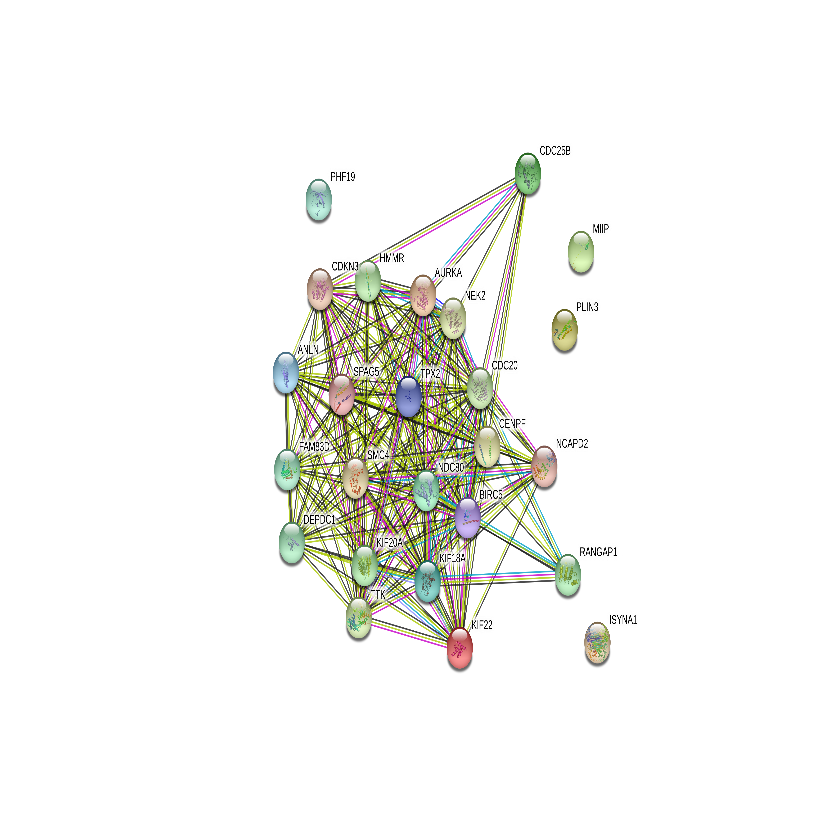

In [26]:
DEGs="All DEGs"
FileName=paste0(DEGs)

#data<-MBcdiffBinomial[[1]] [,2]    # DEGs gene list from Binomial analysis
data<-MBcdiff[[1]] [,2]             # From the table of the differential expression analysis between all pairs of clusters

ppi<-PPI(data,FileName)

networking<-NetAnalysis(ppi)
networking                            ##### In case the Examine response components = 200 and an error "linkmat[i, ]" appeared, that means there are no PPI.

# Plotting the network of the top 25 DEGs
DATA<-data[1:25]
network<-Networking(DATA,FileName,plot_width = 25, plot_height = 10)

### 4.4 Gene Enrichment Analysis

In [27]:
dbs <- listEnrichrDbs()
head(dbs)
#print(dbs)

,geneCoverage,genesPerTerm,libraryName,link,numTerms
,<dbl>,<dbl>,<chr>,<chr>,<dbl>
1,13362,275,Genome_Browser_PWMs,http://hgdownload.cse.ucsc.edu/goldenPath/hg18/database/,615
2,27884,1284,TRANSFAC_and_JASPAR_PWMs,http://jaspar.genereg.net/html/DOWNLOAD/,326
3,6002,77,Transcription_Factor_PPIs,,290
4,47172,1370,ChEA_2013,http://amp.pharm.mssm.edu/lib/cheadownload.jsp,353
5,47107,509,Drug_Perturbations_from_GEO_2014,http://www.ncbi.nlm.nih.gov/geo/,701
6,21493,3713,ENCODE_TF_ChIP-seq_2014,http://genome.ucsc.edu/ENCODE/downloads.html,498


In [28]:
############ Selecting the DEGs' table  ##############
#DEGs=MBcdiffBinomial[[2]][2,4]     # Up-regulated genes in cluster 2 (from the Binomial analysis)
DEGs=MBcdiff[[2]][2,6]              # UP-regulated genes in cluster 2 (from SAMseq)
data<-read.csv(file=paste0(DEGs),head=TRUE,sep=",")
data<-as.character(data[,3])

dbs <- c("KEGG_2013", "GO_Biological_Process_2015")
enriched <- enrichr(data, dbs)
KEGG_2013<-enriched[[1]][,c(1,2,3,9)]
GO_Biological_Process_2015<-enriched[[2]][,c(1,2,3,9)]

GEA<-rbind(KEGG_2013,GO_Biological_Process_2015)
GEA

Uploading data to Enrichr... Done.
  Querying KEGG_2013... Done.
  Querying GO_Biological_Process_2015... Done.
Parsing results... Done.


Term,Overlap,P.value,Genes
<chr>,<chr>,<dbl>,<chr>
HSA04110 CELL CYCLE,11/115,6.014797e-11,CDC20;CCNA2;CCNB2;CCNB1;CDC27;PLK1;BUB1B;BUB3;BUB1;CDC25B;MAD2L1
HSA04120 UBIQUITIN MEDIATED PROTEOLYSIS,3/40,1.566972e-03,CDC20;UBE2C;CDC27
HSA05130 PATHOGENIC ESCHERICHIA COLI INFECTION EHEC,3/53,3.519592e-03,TUBA1C;TUBB6;TUBB2A
HSA05131 PATHOGENIC ESCHERICHIA COLI INFECTION EPEC,3/53,3.519592e-03,TUBA1C;TUBB6;TUBB2A
HSA04540 GAP JUNCTION,3/98,1.897360e-02,TUBA1C;TUBB6;TUBB2A
HSA00780 BIOTIN METABOLISM,1/4,2.280392e-02,BTD
HSA04115 P53 SIGNALING PATHWAY,2/68,5.841184e-02,CCNB2;CCNB1
HSA00440 AMINOPHOSPHONATE METABOLISM,1/16,8.816835e-02,PRMT2
HSA00626 NAPHTHALENE AND ANTHRACENE DEGRADATION,1/18,9.863286e-02,PRMT2
